In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Activation,
    Input,
    BatchNormalization,
    Conv1D,
    Flatten,
    MaxPooling1D,
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping # early stopping
from tensorflow.keras.regularizers import l1
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt
import seaborn as sns

from confusion_matrix import plot_confusion_matrix
sns.set()

In [50]:
from pylab import rcParams

rcParams['figure.figsize'] = 12, 8

In [3]:
RANDOM_SEED = 333
np.random.seed(RANDOM_SEED)

## Prepare data

In [4]:
from sklearn.preprocessing import OneHotEncoder


def one_hot_dna(sequence):
    seq_array = np.array(list(sequence))

    # one hot encoding
    onehot_encoder = OneHotEncoder(sparse=False)
    # reshape because that's what OneHotEncoder likes
    seq_array = seq_array.reshape(len(seq_array), 1)
    onehot_encoded_seq = onehot_encoder.fit_transform(seq_array)
    return onehot_encoded_seq

In [5]:
with open('pseudogenes_50_last.txt', 'r') as file:
    target_sequences = np.array([line.strip().upper() for line in file.readlines() if all(base in set(line) for base in 'ACTG')])
with open('pseudogenes_50_last_shuffled.txt', 'r') as file:
    non_target_sequences = np.array([line.strip().upper() for line in file.readlines() if all(base in set(line) for base in 'ACTG')])
    
CLASS_NAMES = ['P_Pseudo', 'Shuffled']

In [6]:
target_sequences.shape, non_target_sequences.shape

((9971,), (20198,))

In [7]:
if target_sequences.shape[0] > non_target_sequences.shape[0]:
    target_sequences_n = np.random.choice(
        target_sequences,
        non_target_sequences.shape[0],
    )
    non_target_sequences_n = non_target_sequences
else:
    target_sequences_n = target_sequences
    non_target_sequences_n = np.random.choice(
        non_target_sequences,
        target_sequences.shape[0],
    )



X = np.concatenate((target_sequences_n, non_target_sequences_n))
Y = pd.Series(np.append(
    np.full(target_sequences_n.shape[0], 1),
    np.full(non_target_sequences_n.shape[0], 0))
)


In [8]:
X = np.array([one_hot_dna(line) for line in X])
Y = keras.utils.to_categorical(Y)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=RANDOM_SEED)

In [10]:
X.shape

(19942, 50, 4)

## Model 

In [11]:
print(tf.VERSION)
print(keras.__version__)

1.13.1
2.2.4-tf


In [12]:
num_classes = 2
seq_len = len(X[0]) # 50
nucleotides_count = len(X[0][0]) # 4
epochs = 10
batch_size = 100

In [14]:
model = Sequential()
model.add(Conv1D(50, 9, activation='relu', padding='same', input_shape=(seq_len, nucleotides_count)))
model.add(MaxPooling1D(3))
# model.add(Conv1D(seq_len, 3, activation='relu',))
# model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 50)            1850      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 50)            0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 50)            0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                51264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total para

In [16]:
history = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
)

Train on 13460 samples, validate on 1496 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
13460/13460 [==============================] - 1s 95us/sample - loss: 0.6886 - acc: 0.5402 - val_loss: 0.6685 - val_acc: 0.5983
Epoch 2/10
13460/13460 [==============================] - 1s 52us/sample - loss: 0.6512 - acc: 0.6163 - val_loss: 0.6218 - val_acc: 0.6364
Epoch 3/10
13460/13460 [==============================] - 1s 50us/sample - loss: 0.6091 - acc: 0.6620 - val_loss: 0.5811 - val_acc: 0.6939
Epoch 4/10
13460/13460 [==============================] - 1s 50us/sample - loss: 0.5825 - acc: 0.6894 - val_loss: 0.5611 - val_acc: 0.7112
Epoch 5/10
13460/13460 [==============================] - 1s 50us/sample - loss: 0.5683 - acc: 0.7009 - val_loss: 0.5521 - val_acc: 0.7066
Epoch 6/10
13460/13460 [==============================] - 1s 50us/sample - loss: 0.5545 - acc: 0.7122 - val_loss: 0.5467 - val_acc: 0.7052
Epoch 7/10
13460/13460 [==============================] - 1s 52us/sam

In [17]:
# New
score = model.evaluate(X_test, Y_test,
                       batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

4986/4986 [==============================] - 0s 23us/sample - loss: 0.5529 - acc: 0.7186


Test score: 0.5529365936675992
Test accuracy: 0.71861213


In [18]:
Y_pred = model.predict_classes(X_test, verbose=1)

4986/4986 [==============================] - 0s 56us/sample


Normalized confusion matrix
[[0.83513405 0.16486595]
 [0.39847205 0.60152795]]


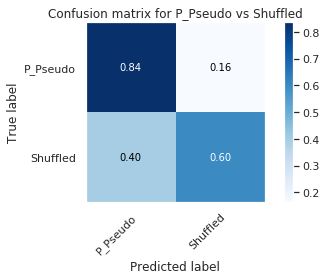

In [19]:
Y_test_flat = np.array(list(map(lambda x: x[1]==1 and 1 or 0, Y_test)))
with sns.axes_style("darkgrid", {"axes.grid": False}):
    plot_confusion_matrix(
        Y_test_flat,
        Y_pred,
        classes=np.array(CLASS_NAMES),
        normalize=True,
        title=f'Confusion matrix for {CLASS_NAMES[0]} vs {CLASS_NAMES[1]}'
    )

In [20]:
Y_pred_probas = model.predict(X_test, verbose=1)[:,1]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test_flat, Y_pred_probas)
auc_keras = auc(fpr_keras, tpr_keras)


4986/4986 [==============================] - 0s 33us/sample


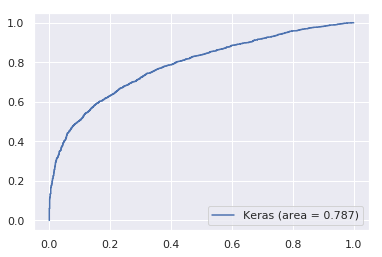

In [21]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.legend(loc='lower right')

In [22]:
#Preparing Indermediate model-removing last sigmoid layer
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('conv1d').output)
intermediate_layer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    (None, 50, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 50)            1850      
Total params: 1,850
Trainable params: 1,850
Non-trainable params: 0
_________________________________________________________________


In [23]:
abc = intermediate_layer_model.predict(np.expand_dims(X_test[0], axis=0))

In [24]:
len(abc[0])

50

In [25]:
sum(abc[0][1])

0.8598492592573166

In [26]:
abc[0][1]


array([0.        , 0.        , 0.        , 0.12040411, 0.        ,
       0.05146318, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.1507902 ,
       0.0960687 , 0.        , 0.14137957, 0.        , 0.        ,
       0.        , 0.00648642, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.012343  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.15199462, 0.        , 0.        , 0.12891948, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [27]:
np.savetxt("temp.csv", abc[0], delimiter=",")

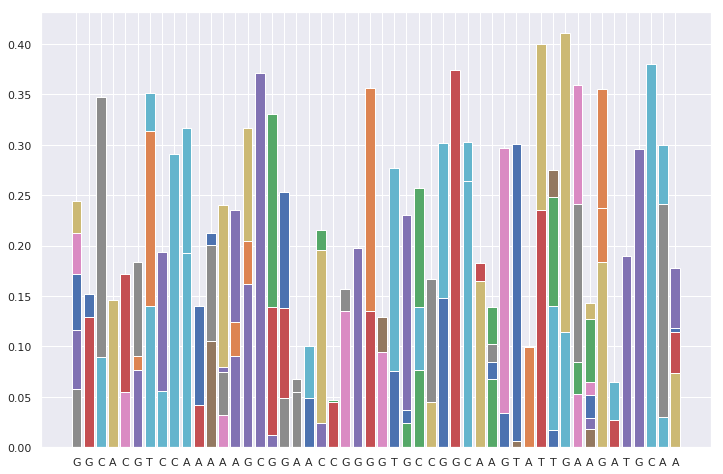

In [64]:
plt.xticks(list(range(1,51)), tmp)
for arr in abc[0].T:
#     plt.bar(tmp, arr)
    plt.bar(list(range(1,51)), arr)
# plt.bar(list(range(1,51)), abc[0][:,1])

In [43]:
abc[0][:,][0] == abc[0][:,1]

array([ True, False,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True, False, False,  True,  True, False,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True, False, False,
        True, False, False,  True,  True])

In [47]:
abc[0].T[0,:] == abc[0][:,0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [52]:
abc[0][:,0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.21233149, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.25312126, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.08065166, 0.        , 0.        ,
       0.        , 0.03447679, 0.        , 0.        , 0.        ,
       0.1598326 , 0.        , 0.        , 0.23354973, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [57]:
list(map(lambda x: x[0] and 'A' or x[1] and 'C' or x[2] and 'T' or x[3] and 'G', X_test[0]))

['G',
 'G',
 'C',
 'A',
 'C',
 'G',
 'T',
 'C',
 'C',
 'A',
 'A',
 'A',
 'A',
 'A',
 'G',
 'C',
 'G',
 'G',
 'A',
 'A',
 'C',
 'C',
 'G',
 'G',
 'G',
 'G',
 'T',
 'G',
 'C',
 'C',
 'G',
 'G',
 'C',
 'A',
 'A',
 'G',
 'T',
 'A',
 'T',
 'T',
 'G',
 'A',
 'A',
 'G',
 'A',
 'T',
 'G',
 'C',
 'A',
 'A']

In [60]:
tmp = list(map(lambda x: x[0] and 'A' or x[1] and 'C' or x[2] and 'T' or x[3] and 'G', X_test[0]))

In [65]:
''.join(tmp)

'GGCACGTCCAAAAAGCGGAACCGGGGTGCCGGCAAGTATTGAAGATGCAA'

In [68]:
weights = intermediate_layer_model.get_weights()

In [70]:
len(weights)

2

In [72]:
weights[0].shape

(9, 4, 50)

In [73]:
weights[1].shape

(50,)

In [76]:
list(enumerate(weights[1]))

[(0, -0.044067908),
 (1, -0.027067872),
 (2, -0.01794202),
 (3, -0.05890596),
 (4, -0.0074881385),
 (5, -0.018454056),
 (6, -0.04063583),
 (7, -0.059400793),
 (8, -0.02135354),
 (9, -0.031166071),
 (10, -0.020166585),
 (11, -0.03091251),
 (12, -0.02551307),
 (13, -0.04569854),
 (14, -0.04243995),
 (15, -0.037581548),
 (16, -0.0070593),
 (17, -0.016255386),
 (18, -0.034860007),
 (19, -0.015887583),
 (20, -0.041035492),
 (21, -0.031199757),
 (22, -0.049188763),
 (23, -0.019499153),
 (24, -0.010155387),
 (25, -0.014134771),
 (26, -0.020115051),
 (27, -0.025978843),
 (28, -0.029503228),
 (29, -0.04445637),
 (30, -0.052959338),
 (31, -0.0762123),
 (32, -0.12619233),
 (33, -0.064212896),
 (34, -0.068661034),
 (35, -0.014178973),
 (36, -0.025752174),
 (37, -0.040019445),
 (38, -0.04360886),
 (39, -0.025380181),
 (40, -0.030185224),
 (41, -0.042787015),
 (42, -0.01398427),
 (43, 0.018097376),
 (44, -0.059883084),
 (45, -0.046088766),
 (46, -0.011247254),
 (47, 0.00078073714),
 (48, -0.02694956

In [77]:
abc[0][:,43]

array([0.        , 0.12891948, 0.        , 0.        , 0.1717746 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04227116, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.13925569, 0.13821855, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.06915971, 0.13520557,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.37405065, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.11432578],
      dtype=float32)

In [78]:
abc[0][:,47]

array([0.05767085, 0.        , 0.34713033, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04859332, 0.05444691, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.16476421, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00062095, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.09413698, 0.        , 0.        ],
      dtype=float32)

In [79]:
abc[0][:,48]

array([0.        , 0.        , 0.        , 0.14652802, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04538103,
       0.        , 0.        , 0.        , 0.16509607, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.07343224],
      dtype=float32)